In [ ]:
TP3 


In [1]:
# !pip install pandas scikit-learn matplotlib seaborn streamlit --quiet
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
# Modeling
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Regressors
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [2]:
DATAFILE = Path("SCFP2009panel.xlsx")
assert DATAFILE.exists(), "Put SCFP2009panel.xlsx in this folder."
dataset = pd.read_excel(DATAFILE)
dataset.shape, type(dataset)

((19285, 515), pandas.core.frame.DataFrame)

In [3]:
dataset.head(3)

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,NHMORTPCT,WAGEINCPCT,BUSSEFARMINCPCT,INTDIVINCPCT,KGINCPCT,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I
0,1,11,11668.134198,47,3,12,2,1,0,2,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,270.403054,57
1,1,12,11823.456494,47,3,12,2,1,0,2,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,249.593620,57
2,1,13,11913.228354,47,3,12,2,1,0,2,...,-50.000000,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,209.233358,57


1/ L'output indique 3 rows × 515 columns pour cet extrait.
2/ L’objectif business est de prédire la tolérance au risque d’un investisseur à partir de ces information
3/Il est donc essentiel de filtrer strictement les variables 2007 pour construire un prédicteur réaliste de la tolérance au risque.


In [4]:
#Average SP500 during 2007 and 2009
# used to normalize 2009 risky assets
Average_SP500_2007=1478
Average_SP500_2009=948

# Risk-free and risky assets (2007)
dataset['RiskFree07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07'] 
dataset['RT07'] = dataset['Risky07']/(dataset['Risky07']+dataset['RiskFree07'])

# Risk-free and risky assets (2009)
dataset['RiskFree09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09'] 
dataset['RT09'] = dataset['Risky09']/(dataset['Risky09']+dataset['RiskFree09'])*\
                (Average_SP500_2009/Average_SP500_2007)
dataset2 = copy.deepcopy(dataset)  
dataset2['PercentageChange'] = np.abs(dataset2['RT09']/dataset2['RT07']-1)
dataset2.head()

# dealing with missing values 

#Checking for any null values and removing the null values'''
print('Null Values =',dataset2.isnull().values.any())
# Drop the rows containing NA
dataset2=dataset2.dropna(axis=0)

dataset2=dataset2[~dataset2.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

#Checking for any null values and removing the null values'''
print('Null Values =',dataset2.isnull().values.any())
dataset2.shape


Null Values = True
Null Values = False


(7956, 522)

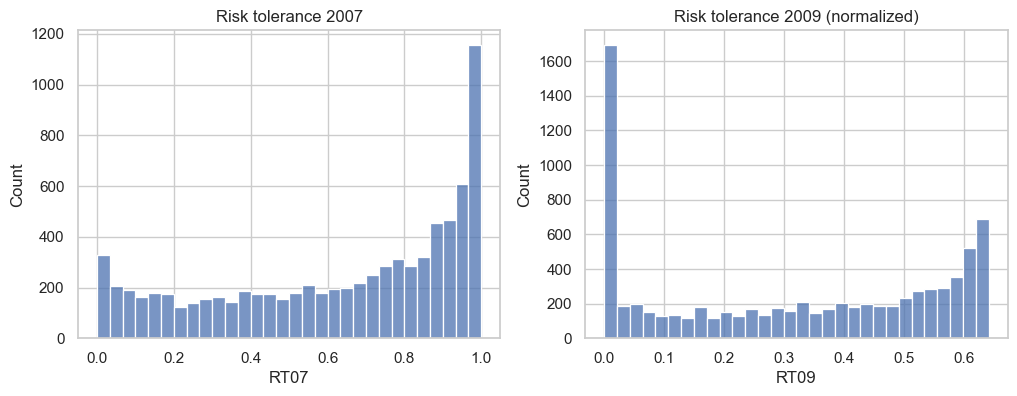

In [5]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(dataset2["RT07"].clip(0,1), bins=30, ax=axes[0])
axes[0].set_title("Risk tolerance 2007")
sns.histplot(dataset2["RT09"].clip(0,1), bins=30, ax=axes[1])
axes[1].set_title("Risk tolerance 2009 (normalized)")
plt.show()


In [6]:
dataset3 = copy.deepcopy(dataset2) 
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09'])/2
dataset3.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)
dataset3.drop(labels=['PercentageChange'], axis=1, inplace=True)

1/ Cette condition permet d’identifier les ménages dont la préférence de risque est structurelle, et non opportuniste ou émotionnelle.
2/Il y a trois raisons principales, à la fois business et ML
    1. Cohérence économique
    La tolérance au risque est un score normalisé
    Par définition :
    0 = très averses au risque
    1 = très tolérants au risque
    Des valeurs < 0 ou > 1 n’ont aucun sens économique
    
    2. Robustesse du modèle
    Le clipping :
    évite l’influence d’outliers extrêmes
    stabilise l’apprentissage
    améliore la convergence des modèles (régression, RF, NN)

    3. Interprétabilité
    Les prédictions deviennent :
    comparables entre individus
    interprétables par des équipes non techniques (finance, conseil, banque)

In [7]:
keep = ["AGE07","EDCL07","MARRIED07","KIDS07","OCCAT107","INCOME07","RISK07","NETWORTH07","TrueRiskTolerance"]
# If your file uses alternate names, remap them first using COLS dict.
Xy = dataset3[keep].dropna().copy()
X = Xy.drop(columns=["TrueRiskTolerance"])
y = Xy["TrueRiskTolerance"]
X.shape, y.shape


((7956, 8), (7956,))

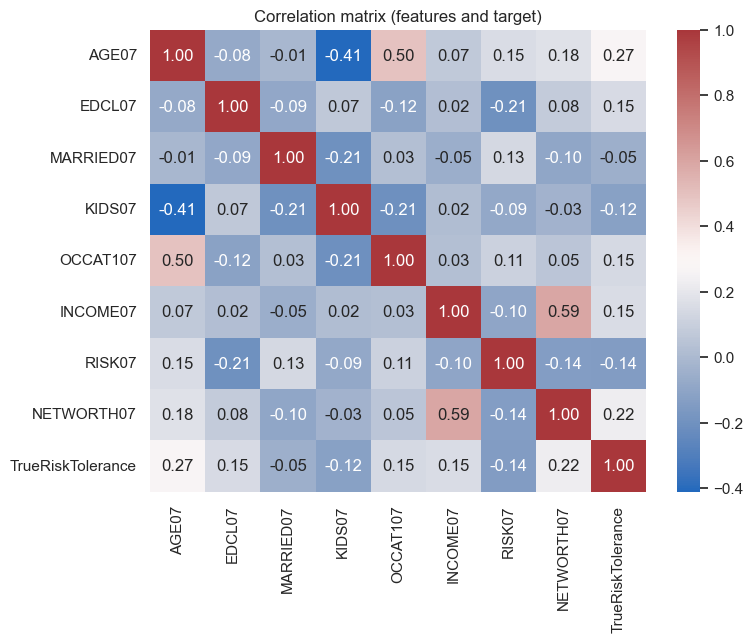

In [8]:
corr = Xy.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation matrix (features and target)")
plt.show()


<Figure size 1500x1500 with 0 Axes>

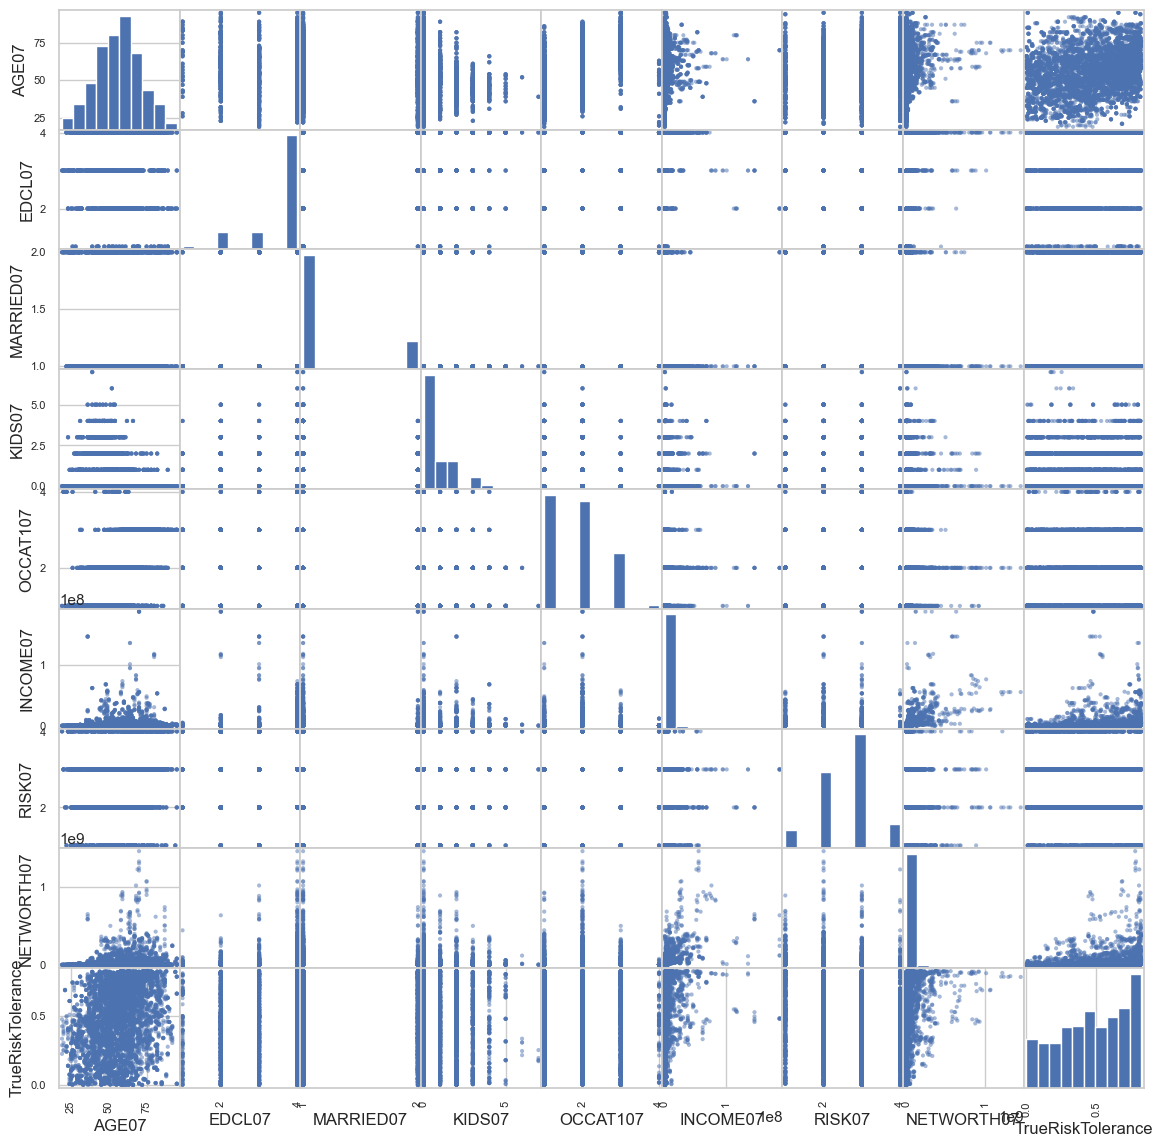

In [9]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
plt.figure(figsize=(15,15))
scatter_matrix(Xy,figsize=(14,14))
plt.show()


1/ Les variables qui corrèlent positivement avec TrueRiskTolerance sont principalement l’âge, le revenu, le patrimoine net, le niveau d’éducation et la catégorie socioprofessionnelle. Cela indique que les individus disposant de plus de ressources financières et d’un capital humain plus élevé ont tendance à être plus tolérants au risque. À l’inverse, le nombre d’enfants, le statut marital et la variable RISK07 présentent une corrélation négative, traduisant une plus grande prudence chez les ménages ayant davantage de responsabilités ou une perception plus élevée du risque.

2/Les variables de 2009 sont exclues afin d’éviter toute fuite d’information, car elles contiennent des données postérieures à 2007 et influencées par la crise financière. Les inclure conduirait à un biais de regard vers le futur et à des performances artificiellement élevées, rendant le modèle irréaliste et non exploitable en pratique.

In [10]:
from sklearn.model_selection import train_test_split
# Expect dataset3 to already exist from earlier parts, with the 2007 features + TrueRiskTolerance
Y = dataset3["TrueRiskTolerance"].astype(float)
X = dataset3.drop(columns=["TrueRiskTolerance"]).copy()
validation_size = 0.20
seed = 3
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, Y, test_size=validation_size, random_state=seed
)
len(X_train), len(X_validation)

(6364, 1592)

In [11]:
y_mean = Y_train.mean()
mae_baseline = mean_absolute_error(Y_validation, np.full_like(Y_validation, y_mean))
rmse_baseline = mean_squared_error(Y_validation, np.full_like(Y_validation, y_mean))
r2_baseline = r2_score(Y_validation, np.full_like(Y_validation, y_mean))
mae_baseline, rmse_baseline, r2_baseline


(0.20404497392111756, 0.05719775394132474, -4.748155845679669e-05)

1/ On calcule une baseline naïve afin de disposer d’un point de comparaison simple et transparent. Elle permet de vérifier que les modèles plus complexes apportent une réelle valeur ajoutée par rapport à une prédiction triviale, ici la moyenne de la tolérance au risque, et d’éviter d’interpréter comme performants des modèles qui ne feraient pas mieux que ce minimum de référence.

2/Pour ce cas d’usage, la métrique à privilégier est le RMSE, car elle pénalise davantage les erreurs importantes. En contexte financier, une forte erreur de prédiction sur la tolérance au risque d’un investisseur peut conduire à des recommandations inadaptées et potentiellement coûteuses, ce qui rend la sensibilité du RMSE aux grosses erreurs particulièrement pertinente.

3/Un R² négatif signifie que le modèle fait moins bien qu’une prédiction naïve basée sur la moyenne de la variable cible. Autrement dit, le modèle n’explique pas la variance de la tolérance au risque et introduit plus d’erreur qu’une approche sans apprentissage, ce qui indique qu’il n’est pas exploitable en l’état.

In [15]:
from sklearn.model_selection import KFold
num_folds = 10
scoring = "r2"
cv = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
)
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

models = [
    ("LR", Pipeline([
        ("scaler", StandardScaler()),
        ("m", LinearRegression())
    ])),

    ("LASSO", Pipeline([
        ("scaler", StandardScaler()),
        ("m", Lasso(alpha=0.01, max_iter=20000))  # use less to be faster
    ])),

    ("EN", Pipeline([
        ("scaler", StandardScaler()),
        ("m", ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=20000))  # use less to be faster
    ])),

    ("KNN", Pipeline([
        ("scaler", StandardScaler()),
        ("m", KNeighborsRegressor(n_neighbors=7))
    ])),

    ("CART", DecisionTreeRegressor(random_state=seed)),

    ("SVR", Pipeline([
        ("scaler", StandardScaler()),
        ("m", SVR(C=2.0, epsilon=0.02, kernel="rbf"))
    ])),

    ("ABR", AdaBoostRegressor(random_state=seed)),

    ("GBR", GradientBoostingRegressor(random_state=seed)),

    ("RFR", RandomForestRegressor(
        n_estimators=300,  # use less to be faster
        random_state=seed,
        n_jobs=-1
    )),

    ("ETR", ExtraTreesRegressor(
        n_estimators=300,  # use less to be faster
        random_state=seed,
        n_jobs=-1
    )),
]



LR: R2 mean=-4.289  std=12.376
LASSO: R2 mean=0.505  std=0.019
EN: R2 mean=0.543  std=0.021
KNN: R2 mean=0.565  std=0.017
CART: R2 mean=0.972  std=0.004
SVR: R2 mean=0.963  std=0.006
ABR: R2 mean=0.813  std=0.008
GBR: R2 mean=0.981  std=0.002
RFR: R2 mean=0.992  std=0.002
ETR: R2 mean=0.985  std=0.004


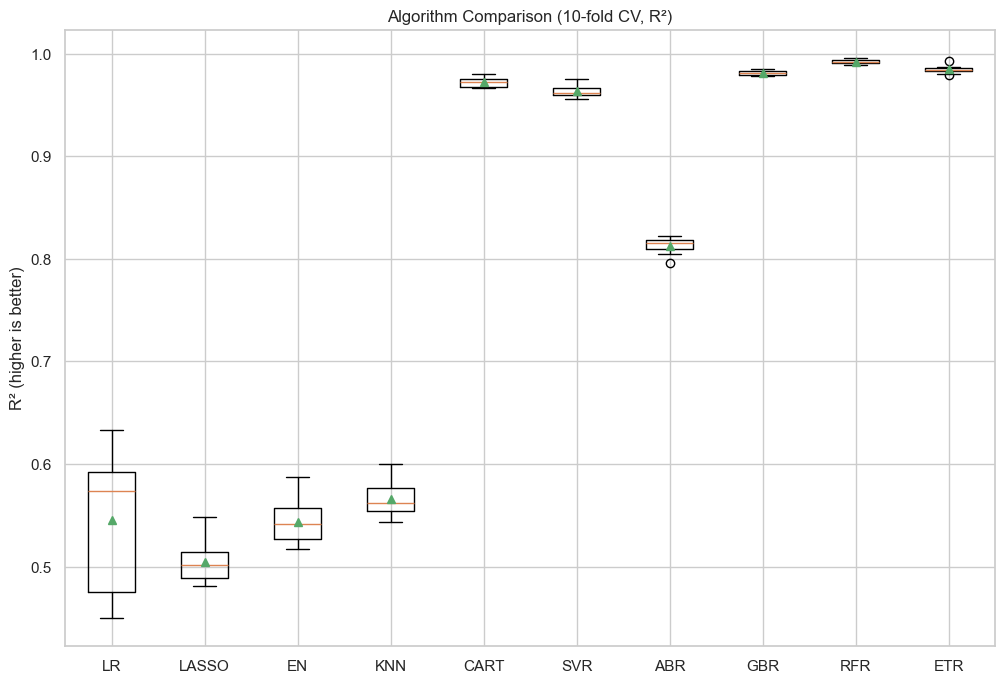

In [17]:
results = []
names = []

for name, model in models:
    cv_scores = cross_val_score(
        model,
        X_train,
        Y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    results.append(cv_scores)
    names.append(name)
    print(f"{name}: R2 mean={cv_scores.mean():.3f}  std={cv_scores.std():.3f}")

plt.figure(figsize=(12,8))
plt.boxplot([np.maximum(res, .45) for res in results], labels=names, showmeans=True)
plt.title("Algorithm Comparison (10-fold CV, R²)")
plt.ylabel("R² (higher is better)")
plt.show()
